In [31]:
import networkx as nx
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time
from collections import Counter
%matplotlib inline 
from tqdm import tqdm

# parameters

alpha = 0.15
a = [1, 2, 4]

def read_folder() : # ok
    all_files = sorted(os.listdir(path = "/Users/danielchoy1314/Downloads/as-733"))
    # print(all_files)
    return all_files

def envolving_graph(file):    
    f = open(file)
    G = nx.Graph()

    n_lines = len(f.readlines())
    # print(n_lines)
    f = open(file)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)

    for i in range(4, n_lines) :
        line = f.readline()      
        line = line[:-1]
        line = line.split("\t")
        a = int(line[0])
        b = int(line[1])
        G.add_edge(a,b)

    f.close()
    return G

def current_graph(file) :
    f = open(file)
    r = nx.Graph()

    n_lines = len(f.readlines())
    # print(n_lines)
    f = open(file)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)
    line = f.readline()
    # print(line)

    for i in range(4, n_lines):
        line = f.readline()
        line = line[:-1]
        line = line.split("\t")
        a = int(line[0])
        b = int(line[1])
        r.add_edge(a, b)
        
    f.close()
    return r

def update_graph(graph, newnode) :
    G = graph
    E = list(G.edges())

    edge = random.choice(E)
    u = edge[0]
    v = edge[1]

    # change of head
    G.remove_edge(u,v)
    u = newnode
    G.add_edge(u, v)

    return G # new graph


def Priority_probing(current_graph, priority, pagerank) :
    # priority in main function
    while True :
        if all (prior == 0 for prior in priority.values()) :
            picked_node = random.choice(list(priority.keys()))
        else :
            picked_node = max(priority, key=lambda k: priority[k])
        if(current_graph.has_node(picked_node)==True) :
            break
        else :
            priority[picked_node] = 0
            
        print(picked_node) 
    
    
    for node in list(current_graph.nodes()) :
        if node != picked_node :
            priority[node] = (priority[node] + pagerank[node]) if node in list(priority.keys()) else (0 + pagerank[node])
        else : 
            priority[node] = 0
            
        if priority[node] > 1 :
            priority[node] = 1
        
    return picked_node, priority


def PowerIteration(graph) :
    V = list(graph.nodes())
    n = len(V)
    for i in range(len(V)):
        v = V[i]
        graph.nodes[v]["old_pi"] = 1/n
        graph.nodes[v]["new_pi"] = 1/n

    # power iterations
    iterations_count = 0
    while True:
        iterations_count += 1  # (pi(1)->pi(t))
        # iterate
        for i in range(len(V)):
            v = V[i]
            graph.nodes[v]["old_pi"] = graph.nodes[v]["new_pi"]
            graph.nodes[v]["new_pi"] = 0

        for i in range(len(V)):
            v = V[i]
            temp = 0
            for u in graph.neighbors(v):
                temp += graph.nodes[u]["old_pi"] / len(list(graph.neighbors(u)))
            graph.nodes[v]["new_pi"] = (1 - alpha) * temp + alpha / n

        # check convergence
        tol = 0
        for i in range(len(V)):
            v = V[i]
            tol += np.abs(graph.nodes[v]["old_pi"] - graph.nodes[v]["new_pi"])

        if tol < 1e-9:
            # print("convergence")
            break

    # set an attribute true pagerank pi to all nodes

    pagerank = {}
    for i in range(len(V)):
        v = V[i]
        pagerank[v] = graph.nodes[v]["new_pi"]
        graph.nodes[v]["real.pi"] = graph.nodes[v]["new_pi"]

    return pagerank

def L_error(true_pi, estimated_pi) :
    # L1 = sum of (estimated_pi - true_pi) at any time step t
    # Linfinity = max error of pagerank
    
    list = []
    for key in true_pi:
        if key not in list:
            list.append(key)

    for key in estimated_pi:
        if key not in list:
            list.append(key)
     
    check= len(set(list)) == len(list)
    
    if(check) : # whether all distinct node
        print("True")
    else :
        print("false")
        
    # print(true_pi[list[1]])
    # print(estimated_pi[list[1]])
    # print(list[1])
    # print(len(list))    
    result = np.zeros(len(list))

    # print(estimated_pi(list[1]))
    # print(len(list))
    
    count = 0
    for i in range(len(list)) :
        if((list[i] in estimated_pi) and (list[i] in true_pi )) :
            result[i] = abs((estimated_pi[list[i]])-(true_pi[list[i]]))          
        elif ((list[i] in estimated_pi) and (list[i] not in true_pi)) :
            result[i] = estimated_pi[list[i]]            
        else :
            result[i] = true_pi[list[i]] 
        count+=result[i]
        
    # print(count)
    # print(max(result))
    return count , max(result)


In [32]:
list_of_file = read_folder()

for i in range(len(list_of_file)) :
    list_of_file[i] = "/Users/danielchoy1314/Downloads/as-733/" + list_of_file[i]  
    
# print(len(list_of_file))

G = envolving_graph(list_of_file[0])
# print(len(list(G.edges())))

K = 1 # recomputing frequency 
changes = []
L1_metric = []
Linfinity_metric = []

priority = dict.fromkeys(list(G.nodes()),0)

for i in tqdm(range(1,len(list_of_file)),desc="Loading…", ascii=False, ncols=75) :
    g = current_graph(list_of_file[i])
    true_pi = PowerIteration(g) 
#______________________________________________________________________# 
    node , priority = Priority_probing(g, priority, true_pi)
    G = update_graph(G, node) 
    changes.append(i)

    estimated_pi = PowerIteration(G)
    
    L1_error, Linfinity_error = L_error(true_pi, estimated_pi)
    L1_metric.append(L1_error)
    Linfinity_metric.append(Linfinity_error)

    
print("Complete")

Loading…:   0%|                          | 1/732 [00:05<1:04:05,  5.26s/it]

True


Loading…:   0%|                          | 2/732 [00:10<1:04:41,  5.32s/it]

True


Loading…:   0%|                          | 3/732 [00:15<1:04:14,  5.29s/it]

True


Loading…:   1%|▏                         | 4/732 [00:21<1:04:14,  5.29s/it]

True


Loading…:   1%|▏                         | 5/732 [00:26<1:03:02,  5.20s/it]

True


Loading…:   1%|▏                         | 6/732 [00:31<1:03:17,  5.23s/it]

True


Loading…:   1%|▏                         | 7/732 [00:36<1:03:26,  5.25s/it]

True


Loading…:   1%|▎                         | 8/732 [00:42<1:03:35,  5.27s/it]

True


Loading…:   1%|▎                         | 9/732 [00:47<1:03:42,  5.29s/it]

True


Loading…:   1%|▎                        | 10/732 [00:52<1:03:34,  5.28s/it]

True


Loading…:   2%|▍                        | 11/732 [00:58<1:05:42,  5.47s/it]

True


Loading…:   2%|▍                        | 12/732 [01:03<1:04:46,  5.40s/it]

True


Loading…:   2%|▍                        | 13/732 [01:09<1:04:25,  5.38s/it]

True


Loading…:   2%|▍                        | 14/732 [01:14<1:04:14,  5.37s/it]

True


Loading…:   2%|▌                        | 15/732 [01:19<1:03:50,  5.34s/it]

True


Loading…:   2%|▌                        | 16/732 [01:25<1:03:57,  5.36s/it]

True


Loading…:   2%|▌                        | 17/732 [01:30<1:03:43,  5.35s/it]

True


Loading…:   2%|▌                        | 18/732 [01:35<1:03:20,  5.32s/it]

True


Loading…:   3%|▋                        | 19/732 [01:41<1:03:12,  5.32s/it]

True


Loading…:   3%|▋                        | 20/732 [01:46<1:02:58,  5.31s/it]

True


Loading…:   3%|▋                        | 21/732 [01:51<1:02:55,  5.31s/it]

True


Loading…:   3%|▊                        | 22/732 [01:57<1:02:47,  5.31s/it]

True


Loading…:   3%|▊                        | 23/732 [02:02<1:02:49,  5.32s/it]

True


Loading…:   3%|▊                        | 24/732 [02:07<1:02:34,  5.30s/it]

True


Loading…:   3%|▊                        | 25/732 [02:13<1:02:52,  5.34s/it]

True


Loading…:   4%|▉                        | 26/732 [02:18<1:03:03,  5.36s/it]

True


Loading…:   4%|▉                        | 27/732 [02:23<1:03:21,  5.39s/it]

True


Loading…:   4%|▉                        | 28/732 [02:29<1:04:23,  5.49s/it]

True


Loading…:   4%|▉                        | 29/732 [02:34<1:03:51,  5.45s/it]

True


Loading…:   4%|█                        | 30/732 [02:40<1:03:30,  5.43s/it]

True


Loading…:   4%|█                        | 31/732 [02:45<1:03:49,  5.46s/it]

True


Loading…:   4%|█                        | 32/732 [02:51<1:03:42,  5.46s/it]

True


Loading…:   5%|█▏                       | 33/732 [02:56<1:03:03,  5.41s/it]

True


Loading…:   5%|█▏                       | 34/732 [03:02<1:03:10,  5.43s/it]

True


Loading…:   5%|█▏                       | 35/732 [03:07<1:02:56,  5.42s/it]

True


Loading…:   5%|█▏                       | 36/732 [03:12<1:02:49,  5.42s/it]

True


Loading…:   5%|█▎                       | 37/732 [03:18<1:02:44,  5.42s/it]

True


Loading…:   5%|█▎                       | 38/732 [03:23<1:02:21,  5.39s/it]

True


Loading…:   5%|█▎                       | 39/732 [03:29<1:02:09,  5.38s/it]

True


Loading…:   5%|█▎                       | 40/732 [03:34<1:02:32,  5.42s/it]

True


Loading…:   6%|█▍                       | 41/732 [03:40<1:02:43,  5.45s/it]

True


Loading…:   6%|█▍                       | 42/732 [03:45<1:02:18,  5.42s/it]

True


Loading…:   6%|█▍                       | 43/732 [03:50<1:01:56,  5.39s/it]

True


Loading…:   6%|█▌                       | 44/732 [03:56<1:03:12,  5.51s/it]

True


Loading…:   6%|█▌                       | 45/732 [04:03<1:07:32,  5.90s/it]

True


Loading…:   6%|█▌                       | 46/732 [04:10<1:10:56,  6.20s/it]

True


Loading…:   6%|█▌                       | 47/732 [04:15<1:08:50,  6.03s/it]

True


Loading…:   7%|█▋                       | 48/732 [04:21<1:08:13,  5.99s/it]

True


Loading…:   7%|█▋                       | 49/732 [04:27<1:06:01,  5.80s/it]

True


Loading…:   7%|█▋                       | 50/732 [04:32<1:05:15,  5.74s/it]

True


Loading…:   7%|█▋                       | 51/732 [04:38<1:03:57,  5.64s/it]

True


Loading…:   7%|█▊                       | 52/732 [04:43<1:03:33,  5.61s/it]

True


Loading…:   7%|█▊                       | 53/732 [04:49<1:02:56,  5.56s/it]

True


Loading…:   7%|█▊                       | 54/732 [04:54<1:02:08,  5.50s/it]

True


Loading…:   8%|█▉                       | 55/732 [04:59<1:01:38,  5.46s/it]

True


Loading…:   8%|█▉                       | 56/732 [05:05<1:01:06,  5.42s/it]

True


Loading…:   8%|█▉                       | 57/732 [05:10<1:00:50,  5.41s/it]

True


Loading…:   8%|█▉                       | 58/732 [05:15<1:00:38,  5.40s/it]

True


Loading…:   8%|██                       | 59/732 [05:21<1:00:39,  5.41s/it]

True


Loading…:   8%|██                       | 60/732 [05:26<1:00:16,  5.38s/it]

True


Loading…:   8%|██                       | 61/732 [05:32<1:00:15,  5.39s/it]

True


Loading…:   8%|██                       | 62/732 [05:37<1:00:50,  5.45s/it]

True


Loading…:   9%|██▏                      | 63/732 [05:43<1:01:11,  5.49s/it]

True


Loading…:   9%|██▏                      | 64/732 [05:48<1:01:03,  5.48s/it]

True


Loading…:   9%|██▏                      | 65/732 [05:54<1:00:47,  5.47s/it]

True


Loading…:   9%|██▎                      | 66/732 [05:59<1:00:39,  5.47s/it]

True


Loading…:   9%|██▎                      | 67/732 [06:05<1:00:18,  5.44s/it]

True


Loading…:   9%|██▎                      | 68/732 [06:10<1:00:32,  5.47s/it]

True


Loading…:   9%|██▎                      | 69/732 [06:15<1:00:10,  5.45s/it]

True


Loading…:  10%|██▍                      | 70/732 [06:21<1:00:18,  5.47s/it]

True


Loading…:  10%|██▌                        | 71/732 [06:26<59:46,  5.43s/it]

True


Loading…:  10%|██▋                        | 72/732 [06:32<59:34,  5.42s/it]

True


Loading…:  10%|██▋                        | 73/732 [06:37<59:18,  5.40s/it]

True


Loading…:  10%|██▋                        | 74/732 [06:43<59:30,  5.43s/it]

True


Loading…:  10%|██▊                        | 75/732 [06:48<59:09,  5.40s/it]

True


Loading…:  10%|██▊                        | 76/732 [06:53<59:12,  5.42s/it]

True


Loading…:  11%|██▊                        | 77/732 [06:59<59:13,  5.43s/it]

True


Loading…:  11%|██▉                        | 78/732 [07:04<59:02,  5.42s/it]

True


Loading…:  11%|██▉                        | 79/732 [07:10<59:06,  5.43s/it]

True


Loading…:  11%|██▉                        | 80/732 [07:15<59:08,  5.44s/it]

True


Loading…:  11%|██▉                        | 81/732 [07:21<59:21,  5.47s/it]

True


Loading…:  11%|███                        | 82/732 [07:26<59:03,  5.45s/it]

True


Loading…:  11%|███                        | 83/732 [07:32<58:57,  5.45s/it]

True


Loading…:  11%|███                        | 84/732 [07:37<58:43,  5.44s/it]

True


Loading…:  12%|███▏                       | 85/732 [07:42<58:41,  5.44s/it]

True


Loading…:  12%|███▏                       | 86/732 [07:48<58:09,  5.40s/it]

True


Loading…:  12%|███▏                       | 87/732 [07:53<58:08,  5.41s/it]

True


Loading…:  12%|███▏                       | 88/732 [07:58<58:00,  5.40s/it]

True


Loading…:  12%|███▎                       | 89/732 [08:04<57:57,  5.41s/it]

True


Loading…:  12%|███▎                       | 90/732 [08:09<57:58,  5.42s/it]

True


Loading…:  12%|███▎                       | 91/732 [08:15<58:29,  5.48s/it]

True


Loading…:  13%|███▍                       | 92/732 [08:21<58:44,  5.51s/it]

True


Loading…:  13%|███▍                       | 93/732 [08:26<58:45,  5.52s/it]

True


Loading…:  13%|███▍                       | 94/732 [08:32<58:50,  5.53s/it]

True


Loading…:  13%|███▌                       | 95/732 [08:37<58:47,  5.54s/it]

True


Loading…:  13%|███▌                       | 96/732 [08:43<59:08,  5.58s/it]

True


Loading…:  13%|███▌                       | 97/732 [08:48<59:05,  5.58s/it]

True


Loading…:  13%|███▌                       | 98/732 [08:54<58:28,  5.53s/it]

True


Loading…:  14%|███▋                       | 99/732 [08:59<58:06,  5.51s/it]

True


Loading…:  14%|███▌                      | 100/732 [09:05<57:57,  5.50s/it]

True


Loading…:  14%|███▌                      | 101/732 [09:10<57:54,  5.51s/it]

True


Loading…:  14%|███▌                      | 102/732 [09:16<57:39,  5.49s/it]

True


Loading…:  14%|███▋                      | 103/732 [09:21<58:08,  5.55s/it]

True


Loading…:  14%|███▋                      | 104/732 [09:27<58:05,  5.55s/it]

True


Loading…:  14%|███▋                      | 105/732 [09:33<57:48,  5.53s/it]

True


Loading…:  14%|███▊                      | 106/732 [09:38<57:25,  5.50s/it]

True


Loading…:  15%|███▊                      | 107/732 [09:44<57:42,  5.54s/it]

True


Loading…:  15%|███▊                      | 108/732 [09:49<57:16,  5.51s/it]

True


Loading…:  15%|███▊                      | 109/732 [09:55<57:09,  5.51s/it]

True


Loading…:  15%|███▉                      | 110/732 [10:00<57:03,  5.50s/it]

True


Loading…:  15%|███▉                      | 111/732 [10:06<57:20,  5.54s/it]

True


Loading…:  15%|███▉                      | 112/732 [10:11<57:50,  5.60s/it]

True


Loading…:  15%|████                      | 113/732 [10:17<57:12,  5.54s/it]

True


Loading…:  16%|████                      | 114/732 [10:22<56:55,  5.53s/it]

True


Loading…:  16%|████                      | 115/732 [10:28<56:24,  5.49s/it]

True


Loading…:  16%|████                      | 116/732 [10:33<56:32,  5.51s/it]

True


Loading…:  16%|████▏                     | 117/732 [10:39<56:17,  5.49s/it]

True


Loading…:  16%|████▏                     | 118/732 [10:45<58:11,  5.69s/it]

True


Loading…:  16%|████▏                     | 119/732 [10:50<57:41,  5.65s/it]

True


Loading…:  16%|████▎                     | 120/732 [10:56<57:06,  5.60s/it]

True


Loading…:  17%|████▎                     | 121/732 [11:01<57:08,  5.61s/it]

True


Loading…:  17%|████▎                     | 122/732 [11:07<57:21,  5.64s/it]

True


Loading…:  17%|████▎                     | 123/732 [11:13<57:54,  5.70s/it]

True


Loading…:  17%|████▍                     | 124/732 [11:19<57:30,  5.68s/it]

True


Loading…:  17%|████▍                     | 125/732 [11:24<57:20,  5.67s/it]

True


Loading…:  17%|████▍                     | 126/732 [11:30<57:10,  5.66s/it]

True


Loading…:  17%|████▌                     | 127/732 [11:36<56:52,  5.64s/it]

True


Loading…:  17%|████▌                     | 128/732 [11:41<56:48,  5.64s/it]

True


Loading…:  18%|████▌                     | 129/732 [11:47<56:41,  5.64s/it]

True


Loading…:  18%|████▌                     | 130/732 [11:53<56:48,  5.66s/it]

True


Loading…:  18%|████▋                     | 131/732 [11:58<56:53,  5.68s/it]

True


Loading…:  18%|████▋                     | 132/732 [12:04<57:12,  5.72s/it]

True


Loading…:  18%|████▋                     | 133/732 [12:10<57:23,  5.75s/it]

True


Loading…:  18%|████▊                     | 134/732 [12:16<57:13,  5.74s/it]

True


Loading…:  18%|████▊                     | 135/732 [12:21<56:47,  5.71s/it]

True


Loading…:  19%|████▊                     | 136/732 [12:27<56:25,  5.68s/it]

True


Loading…:  19%|████▊                     | 137/732 [12:33<56:23,  5.69s/it]

True


Loading…:  19%|████▉                     | 138/732 [12:38<55:59,  5.66s/it]

True


Loading…:  19%|████▉                     | 139/732 [12:44<56:05,  5.68s/it]

True


Loading…:  19%|████▉                     | 140/732 [12:49<55:41,  5.64s/it]

True


Loading…:  19%|█████                     | 141/732 [12:55<55:36,  5.64s/it]

True


Loading…:  19%|█████                     | 142/732 [13:01<55:40,  5.66s/it]

True


Loading…:  20%|█████                     | 143/732 [13:06<55:38,  5.67s/it]

True


Loading…:  20%|█████                     | 144/732 [13:12<55:36,  5.67s/it]

True


Loading…:  20%|█████▏                    | 145/732 [13:18<55:24,  5.66s/it]

True


Loading…:  20%|█████▏                    | 146/732 [13:24<55:25,  5.67s/it]

True


Loading…:  20%|█████▏                    | 147/732 [13:29<55:27,  5.69s/it]

True


Loading…:  20%|█████▎                    | 148/732 [13:35<54:15,  5.57s/it]

True


Loading…:  20%|█████▎                    | 149/732 [13:40<54:42,  5.63s/it]

True


Loading…:  20%|█████▎                    | 150/732 [13:46<54:43,  5.64s/it]

True


Loading…:  21%|█████▎                    | 151/732 [13:52<54:53,  5.67s/it]

True


Loading…:  21%|█████▍                    | 152/732 [13:57<54:35,  5.65s/it]

True


Loading…:  21%|█████▍                    | 153/732 [14:03<54:51,  5.68s/it]

True


Loading…:  21%|█████▍                    | 154/732 [14:09<54:56,  5.70s/it]

True


Loading…:  21%|█████▌                    | 155/732 [14:15<55:19,  5.75s/it]

True


Loading…:  21%|█████▌                    | 156/732 [14:20<55:07,  5.74s/it]

True


Loading…:  21%|█████▌                    | 157/732 [14:26<54:59,  5.74s/it]

True


Loading…:  22%|█████▌                    | 158/732 [14:32<54:55,  5.74s/it]

True


Loading…:  22%|█████▋                    | 159/732 [14:38<54:53,  5.75s/it]

True


Loading…:  22%|█████▋                    | 160/732 [14:43<55:00,  5.77s/it]

True


Loading…:  22%|█████▋                    | 161/732 [14:49<54:49,  5.76s/it]

True


Loading…:  22%|█████▊                    | 162/732 [14:55<55:12,  5.81s/it]

True


Loading…:  22%|█████▊                    | 163/732 [15:01<54:42,  5.77s/it]

True


Loading…:  22%|█████▊                    | 164/732 [15:07<54:36,  5.77s/it]

True


Loading…:  23%|█████▊                    | 165/732 [15:12<54:15,  5.74s/it]

True


Loading…:  23%|█████▉                    | 166/732 [15:18<54:07,  5.74s/it]

True


Loading…:  23%|█████▉                    | 167/732 [15:24<54:08,  5.75s/it]

True


Loading…:  23%|█████▉                    | 168/732 [15:29<53:47,  5.72s/it]

True


Loading…:  23%|██████                    | 169/732 [15:35<53:48,  5.73s/it]

True


Loading…:  23%|██████                    | 170/732 [15:41<53:40,  5.73s/it]

True


Loading…:  23%|██████                    | 171/732 [15:47<53:44,  5.75s/it]

True


Loading…:  23%|██████                    | 172/732 [15:52<53:39,  5.75s/it]

True


Loading…:  24%|██████▏                   | 173/732 [15:58<53:19,  5.72s/it]

True


Loading…:  24%|██████▏                   | 174/732 [16:04<53:29,  5.75s/it]

True


Loading…:  24%|██████▏                   | 175/732 [16:10<53:26,  5.76s/it]

True


Loading…:  24%|██████▎                   | 176/732 [16:15<53:24,  5.76s/it]

True


Loading…:  24%|██████▎                   | 177/732 [16:21<53:01,  5.73s/it]

True


Loading…:  24%|██████▎                   | 178/732 [16:27<52:56,  5.73s/it]

True


Loading…:  24%|██████▎                   | 179/732 [16:33<52:53,  5.74s/it]

True


Loading…:  25%|██████▍                   | 180/732 [16:38<52:47,  5.74s/it]

True


Loading…:  25%|██████▍                   | 181/732 [16:44<52:53,  5.76s/it]

True


Loading…:  25%|██████▍                   | 182/732 [16:50<52:40,  5.75s/it]

True


Loading…:  25%|██████▌                   | 183/732 [16:56<52:49,  5.77s/it]

True


Loading…:  25%|██████▌                   | 184/732 [17:01<52:36,  5.76s/it]

True


Loading…:  25%|██████▌                   | 185/732 [17:07<52:33,  5.76s/it]

True


Loading…:  25%|██████▌                   | 186/732 [17:13<52:20,  5.75s/it]

True


Loading…:  26%|██████▋                   | 187/732 [17:19<52:02,  5.73s/it]

True


Loading…:  26%|██████▋                   | 188/732 [17:24<51:59,  5.73s/it]

True


Loading…:  26%|██████▋                   | 189/732 [17:30<51:54,  5.74s/it]

True


Loading…:  26%|██████▋                   | 190/732 [17:35<49:14,  5.45s/it]

True


Loading…:  26%|██████▊                   | 191/732 [17:41<49:58,  5.54s/it]

True


Loading…:  26%|██████▊                   | 192/732 [17:47<51:17,  5.70s/it]

True


Loading…:  26%|██████▊                   | 193/732 [17:53<52:06,  5.80s/it]

True


Loading…:  27%|██████▉                   | 194/732 [17:59<52:42,  5.88s/it]

True


Loading…:  27%|██████▉                   | 195/732 [18:05<53:24,  5.97s/it]

True


Loading…:  27%|██████▉                   | 196/732 [18:11<53:33,  5.99s/it]

True


Loading…:  27%|██████▉                   | 197/732 [18:17<53:58,  6.05s/it]

True


Loading…:  27%|███████                   | 198/732 [18:23<54:16,  6.10s/it]

True


Loading…:  27%|███████                   | 199/732 [18:30<54:15,  6.11s/it]

True


Loading…:  27%|███████                   | 200/732 [18:36<54:17,  6.12s/it]

True


Loading…:  27%|███████▏                  | 201/732 [18:42<54:48,  6.19s/it]

True


Loading…:  28%|███████▏                  | 202/732 [18:48<54:02,  6.12s/it]

True


Loading…:  28%|███████▏                  | 203/732 [18:54<53:31,  6.07s/it]

True


Loading…:  28%|███████▏                  | 204/732 [19:00<53:47,  6.11s/it]

True


Loading…:  28%|███████▎                  | 205/732 [19:06<53:30,  6.09s/it]

True


Loading…:  28%|███████▎                  | 206/732 [19:12<53:05,  6.06s/it]

True


Loading…:  28%|███████▎                  | 207/732 [19:18<53:25,  6.11s/it]

True


Loading…:  28%|███████▍                  | 208/732 [19:24<53:07,  6.08s/it]

True


Loading…:  29%|███████▍                  | 209/732 [19:30<52:49,  6.06s/it]

True


Loading…:  29%|███████▍                  | 210/732 [19:36<51:54,  5.97s/it]

True


Loading…:  29%|███████▍                  | 211/732 [19:42<51:42,  5.95s/it]

True


Loading…:  29%|███████▌                  | 212/732 [19:48<51:48,  5.98s/it]

True


Loading…:  29%|███████▌                  | 213/732 [19:54<51:15,  5.93s/it]

True


Loading…:  29%|███████▌                  | 214/732 [20:00<50:59,  5.91s/it]

True


Loading…:  29%|███████▋                  | 215/732 [20:06<50:49,  5.90s/it]

True


Loading…:  30%|███████▋                  | 216/732 [20:12<51:29,  5.99s/it]

True


Loading…:  30%|███████▋                  | 217/732 [20:18<51:29,  6.00s/it]

True


Loading…:  30%|███████▋                  | 218/732 [20:24<51:29,  6.01s/it]

True


Loading…:  30%|███████▊                  | 219/732 [20:30<51:42,  6.05s/it]

True


Loading…:  30%|███████▊                  | 220/732 [20:36<52:10,  6.11s/it]

True


Loading…:  30%|███████▊                  | 221/732 [20:43<52:29,  6.16s/it]

True


Loading…:  30%|███████▉                  | 222/732 [20:49<51:41,  6.08s/it]

True


Loading…:  30%|███████▉                  | 223/732 [20:54<50:48,  5.99s/it]

True


Loading…:  31%|███████▉                  | 224/732 [21:00<50:22,  5.95s/it]

True


Loading…:  31%|███████▉                  | 225/732 [21:06<50:10,  5.94s/it]

True


Loading…:  31%|████████                  | 226/732 [21:12<50:22,  5.97s/it]

True


Loading…:  31%|████████                  | 227/732 [21:18<50:21,  5.98s/it]

True


Loading…:  31%|████████                  | 228/732 [21:24<50:04,  5.96s/it]

True


Loading…:  31%|████████▏                 | 229/732 [21:30<50:25,  6.02s/it]

True


Loading…:  31%|████████▏                 | 230/732 [21:36<50:06,  5.99s/it]

True


Loading…:  32%|████████▏                 | 231/732 [21:42<49:58,  5.98s/it]

True


Loading…:  32%|████████▏                 | 232/732 [21:48<49:52,  5.98s/it]

True


Loading…:  32%|████████▎                 | 233/732 [21:54<49:57,  6.01s/it]

True


Loading…:  32%|████████▎                 | 234/732 [22:00<50:06,  6.04s/it]

True


Loading…:  32%|████████▎                 | 235/732 [22:06<50:20,  6.08s/it]

True


Loading…:  32%|████████▍                 | 236/732 [22:12<50:03,  6.05s/it]

True


Loading…:  32%|████████▍                 | 237/732 [22:18<49:44,  6.03s/it]

True


Loading…:  33%|████████▍                 | 238/732 [22:24<49:22,  6.00s/it]

True


Loading…:  33%|████████▍                 | 239/732 [22:30<49:07,  5.98s/it]

True


Loading…:  33%|████████▌                 | 240/732 [22:36<48:35,  5.93s/it]

True


Loading…:  33%|████████▌                 | 241/732 [22:42<49:05,  6.00s/it]

True


Loading…:  33%|████████▌                 | 242/732 [22:48<49:22,  6.05s/it]

True


Loading…:  33%|████████▋                 | 243/732 [22:55<49:44,  6.10s/it]

True


Loading…:  33%|████████▋                 | 244/732 [23:01<49:34,  6.09s/it]

True


Loading…:  33%|████████▋                 | 245/732 [23:07<49:19,  6.08s/it]

True


Loading…:  34%|████████▋                 | 246/732 [23:13<49:21,  6.09s/it]

True


Loading…:  34%|████████▊                 | 247/732 [23:19<48:26,  5.99s/it]

True


Loading…:  34%|████████▊                 | 248/732 [23:25<48:55,  6.06s/it]

True


Loading…:  34%|████████▊                 | 249/732 [23:31<48:52,  6.07s/it]

True


Loading…:  34%|████████▉                 | 250/732 [23:37<49:28,  6.16s/it]

True


Loading…:  34%|████████▉                 | 251/732 [23:44<49:38,  6.19s/it]

True


Loading…:  34%|████████▉                 | 252/732 [23:50<49:56,  6.24s/it]

True


Loading…:  35%|████████▉                 | 253/732 [23:56<48:31,  6.08s/it]

True


Loading…:  35%|█████████                 | 254/732 [24:02<48:42,  6.11s/it]

True


Loading…:  35%|█████████                 | 255/732 [24:08<48:38,  6.12s/it]

True


Loading…:  35%|█████████                 | 256/732 [24:14<48:57,  6.17s/it]

True


Loading…:  35%|█████████▏                | 257/732 [24:20<48:53,  6.17s/it]

True


Loading…:  35%|█████████▏                | 258/732 [24:26<48:00,  6.08s/it]

True


Loading…:  35%|█████████▏                | 259/732 [24:32<47:38,  6.04s/it]

True


Loading…:  36%|█████████▏                | 260/732 [24:38<46:51,  5.96s/it]

True


Loading…:  36%|█████████▎                | 261/732 [24:44<46:59,  5.99s/it]

True


Loading…:  36%|█████████▎                | 262/732 [24:50<47:00,  6.00s/it]

True


Loading…:  36%|█████████▎                | 263/732 [24:56<47:00,  6.01s/it]

True


Loading…:  36%|█████████▍                | 264/732 [25:02<47:00,  6.03s/it]

True


Loading…:  36%|█████████▍                | 265/732 [25:08<47:19,  6.08s/it]

True


Loading…:  36%|█████████▍                | 266/732 [25:14<47:04,  6.06s/it]

True


Loading…:  36%|█████████▍                | 267/732 [25:21<47:08,  6.08s/it]

True


Loading…:  37%|█████████▌                | 268/732 [25:26<46:14,  5.98s/it]

True


Loading…:  37%|█████████▌                | 269/732 [25:32<45:17,  5.87s/it]

True


Loading…:  37%|█████████▌                | 270/732 [25:38<44:39,  5.80s/it]

True


Loading…:  37%|█████████▋                | 271/732 [25:44<44:56,  5.85s/it]

True


Loading…:  37%|█████████▋                | 272/732 [25:49<45:00,  5.87s/it]

True


Loading…:  37%|█████████▋                | 273/732 [25:55<44:58,  5.88s/it]

True


Loading…:  37%|█████████▋                | 274/732 [26:01<44:55,  5.89s/it]

True


Loading…:  38%|█████████▊                | 275/732 [26:07<44:44,  5.87s/it]

True


Loading…:  38%|█████████▊                | 276/732 [26:13<45:07,  5.94s/it]

True


Loading…:  38%|█████████▊                | 277/732 [26:19<45:01,  5.94s/it]

True


Loading…:  38%|█████████▊                | 278/732 [26:25<44:47,  5.92s/it]

True


Loading…:  38%|█████████▉                | 279/732 [26:31<44:55,  5.95s/it]

True


Loading…:  38%|█████████▉                | 280/732 [26:37<44:45,  5.94s/it]

True


Loading…:  38%|█████████▉                | 281/732 [26:43<44:45,  5.96s/it]

True


Loading…:  39%|██████████                | 282/732 [26:49<44:29,  5.93s/it]

True


Loading…:  39%|██████████                | 283/732 [26:55<44:28,  5.94s/it]

True


Loading…:  39%|██████████                | 284/732 [27:01<44:26,  5.95s/it]

True


Loading…:  39%|██████████                | 285/732 [27:07<44:13,  5.94s/it]

True


Loading…:  39%|██████████▏               | 286/732 [27:13<44:08,  5.94s/it]

True


Loading…:  39%|██████████▏               | 287/732 [27:18<43:57,  5.93s/it]

True


Loading…:  39%|██████████▏               | 288/732 [27:25<44:42,  6.04s/it]

True


Loading…:  39%|██████████▎               | 289/732 [27:31<45:04,  6.10s/it]

True


Loading…:  40%|██████████▎               | 290/732 [27:37<44:39,  6.06s/it]

True


Loading…:  40%|██████████▎               | 291/732 [27:43<44:34,  6.06s/it]

True


Loading…:  40%|██████████▎               | 292/732 [27:49<44:19,  6.04s/it]

True


Loading…:  40%|██████████▍               | 293/732 [27:55<44:07,  6.03s/it]

True


Loading…:  40%|██████████▍               | 294/732 [28:01<44:15,  6.06s/it]

True


Loading…:  40%|██████████▍               | 295/732 [28:07<44:01,  6.04s/it]

True


Loading…:  40%|██████████▌               | 296/732 [28:14<45:16,  6.23s/it]

True


Loading…:  41%|██████████▌               | 297/732 [28:20<46:00,  6.35s/it]

True


Loading…:  41%|██████████▌               | 298/732 [28:27<45:20,  6.27s/it]

True


Loading…:  41%|██████████▌               | 299/732 [28:33<45:05,  6.25s/it]

True


Loading…:  41%|██████████▋               | 300/732 [28:39<44:44,  6.21s/it]

True


Loading…:  41%|██████████▋               | 301/732 [28:45<45:06,  6.28s/it]

True


Loading…:  41%|██████████▋               | 302/732 [28:52<45:16,  6.32s/it]

True


Loading…:  41%|██████████▊               | 303/732 [28:58<44:52,  6.28s/it]

True


Loading…:  42%|██████████▊               | 304/732 [29:04<45:00,  6.31s/it]

True


Loading…:  42%|██████████▊               | 305/732 [29:11<44:45,  6.29s/it]

True


Loading…:  42%|██████████▊               | 306/732 [29:17<44:57,  6.33s/it]

True


Loading…:  42%|██████████▉               | 307/732 [29:23<44:44,  6.32s/it]

True


Loading…:  42%|██████████▉               | 308/732 [29:29<44:20,  6.28s/it]

True


Loading…:  42%|██████████▉               | 309/732 [29:36<44:10,  6.27s/it]

True


Loading…:  42%|███████████               | 310/732 [29:42<44:24,  6.31s/it]

True


Loading…:  42%|███████████               | 311/732 [29:48<44:26,  6.33s/it]

True


Loading…:  43%|███████████               | 312/732 [29:55<44:32,  6.36s/it]

True


Loading…:  43%|███████████               | 313/732 [30:01<44:28,  6.37s/it]

True


Loading…:  43%|███████████▏              | 314/732 [30:08<44:04,  6.33s/it]

True


Loading…:  43%|███████████▏              | 315/732 [30:14<44:16,  6.37s/it]

True


Loading…:  43%|███████████▏              | 316/732 [30:20<43:56,  6.34s/it]

True


Loading…:  43%|███████████▎              | 317/732 [30:27<43:39,  6.31s/it]

True


Loading…:  43%|███████████▎              | 318/732 [30:33<43:53,  6.36s/it]

True


Loading…:  44%|███████████▎              | 319/732 [30:39<43:36,  6.34s/it]

True


Loading…:  44%|███████████▎              | 320/732 [30:46<43:38,  6.35s/it]

True


Loading…:  44%|███████████▍              | 321/732 [30:52<43:25,  6.34s/it]

True


Loading…:  44%|███████████▍              | 322/732 [30:59<43:44,  6.40s/it]

True


Loading…:  44%|███████████▍              | 323/732 [31:05<43:07,  6.33s/it]

True


Loading…:  44%|███████████▌              | 324/732 [31:11<42:34,  6.26s/it]

True


Loading…:  44%|███████████▌              | 325/732 [31:17<42:08,  6.21s/it]

True


Loading…:  45%|███████████▌              | 326/732 [31:23<41:58,  6.20s/it]

True


Loading…:  45%|███████████▌              | 327/732 [31:29<41:42,  6.18s/it]

True


Loading…:  45%|███████████▋              | 328/732 [31:35<41:24,  6.15s/it]

True


Loading…:  45%|███████████▋              | 329/732 [31:41<41:15,  6.14s/it]

True


Loading…:  45%|███████████▋              | 330/732 [31:47<41:02,  6.12s/it]

True


Loading…:  45%|███████████▊              | 331/732 [31:54<40:58,  6.13s/it]

True


Loading…:  45%|███████████▊              | 332/732 [32:00<40:41,  6.10s/it]

True


Loading…:  45%|███████████▊              | 333/732 [32:06<40:48,  6.14s/it]

True


Loading…:  46%|███████████▊              | 334/732 [32:12<40:52,  6.16s/it]

True


Loading…:  46%|███████████▉              | 335/732 [32:18<40:36,  6.14s/it]

True


Loading…:  46%|███████████▉              | 336/732 [32:24<40:24,  6.12s/it]

True


Loading…:  46%|███████████▉              | 337/732 [32:30<40:26,  6.14s/it]

True


Loading…:  46%|████████████              | 338/732 [32:37<40:19,  6.14s/it]

True


Loading…:  46%|████████████              | 339/732 [32:43<40:20,  6.16s/it]

True


Loading…:  46%|████████████              | 340/732 [32:49<40:11,  6.15s/it]

True


Loading…:  47%|████████████              | 341/732 [32:55<40:15,  6.18s/it]

True


Loading…:  47%|████████████▏             | 342/732 [33:01<39:57,  6.15s/it]

True


Loading…:  47%|████████████▏             | 343/732 [33:07<40:03,  6.18s/it]

True


Loading…:  47%|████████████▏             | 344/732 [33:14<40:06,  6.20s/it]

True


Loading…:  47%|████████████▎             | 345/732 [33:20<40:03,  6.21s/it]

True


Loading…:  47%|████████████▎             | 346/732 [33:26<39:59,  6.22s/it]

True


Loading…:  47%|████████████▎             | 347/732 [33:32<39:55,  6.22s/it]

True


Loading…:  48%|████████████▎             | 348/732 [33:39<39:47,  6.22s/it]

True


Loading…:  48%|████████████▍             | 349/732 [33:45<39:52,  6.25s/it]

True


Loading…:  48%|████████████▍             | 350/732 [33:51<39:54,  6.27s/it]

True


Loading…:  48%|████████████▍             | 351/732 [33:58<39:46,  6.26s/it]

True


Loading…:  48%|████████████▌             | 352/732 [34:04<39:49,  6.29s/it]

True


Loading…:  48%|████████████▌             | 353/732 [34:10<39:51,  6.31s/it]

True


Loading…:  48%|████████████▌             | 354/732 [34:17<40:17,  6.40s/it]

True


Loading…:  48%|████████████▌             | 355/732 [34:23<40:31,  6.45s/it]

True


Loading…:  49%|████████████▋             | 356/732 [34:30<40:04,  6.39s/it]

True


Loading…:  49%|████████████▋             | 357/732 [34:36<40:20,  6.45s/it]

True


Loading…:  49%|████████████▋             | 358/732 [34:43<40:32,  6.50s/it]

True


Loading…:  49%|████████████▊             | 359/732 [34:49<39:59,  6.43s/it]

True


Loading…:  49%|████████████▊             | 360/732 [34:56<39:50,  6.43s/it]

True


Loading…:  49%|████████████▊             | 361/732 [35:02<39:36,  6.41s/it]

True


Loading…:  49%|████████████▊             | 362/732 [35:08<39:11,  6.35s/it]

True


Loading…:  50%|████████████▉             | 363/732 [35:15<39:11,  6.37s/it]

True


Loading…:  50%|████████████▉             | 364/732 [35:21<39:06,  6.38s/it]

True


Loading…:  50%|████████████▉             | 365/732 [35:27<39:03,  6.38s/it]

True


Loading…:  50%|█████████████             | 366/732 [35:34<38:57,  6.39s/it]

True


Loading…:  50%|█████████████             | 367/732 [35:40<38:50,  6.38s/it]

True


Loading…:  50%|█████████████             | 368/732 [35:47<38:44,  6.39s/it]

True


Loading…:  50%|█████████████             | 369/732 [35:53<38:49,  6.42s/it]

True


Loading…:  51%|█████████████▏            | 370/732 [36:00<38:58,  6.46s/it]

True


Loading…:  51%|█████████████▏            | 371/732 [36:06<38:40,  6.43s/it]

True


Loading…:  51%|█████████████▏            | 372/732 [36:12<38:46,  6.46s/it]

True


Loading…:  51%|█████████████▏            | 373/732 [36:19<38:35,  6.45s/it]

True


Loading…:  51%|█████████████▎            | 374/732 [36:25<38:26,  6.44s/it]

True


Loading…:  51%|█████████████▎            | 375/732 [36:32<38:19,  6.44s/it]

True


Loading…:  51%|█████████████▎            | 376/732 [36:38<38:11,  6.44s/it]

True


Loading…:  52%|█████████████▍            | 377/732 [36:45<38:28,  6.50s/it]

True


Loading…:  52%|█████████████▍            | 378/732 [36:51<38:11,  6.47s/it]

True


Loading…:  52%|█████████████▍            | 379/732 [36:58<38:22,  6.52s/it]

True


Loading…:  52%|█████████████▍            | 380/732 [37:04<38:16,  6.53s/it]

True


Loading…:  52%|█████████████▌            | 381/732 [37:11<38:22,  6.56s/it]

True


Loading…:  52%|█████████████▌            | 382/732 [37:17<37:59,  6.51s/it]

True


Loading…:  52%|█████████████▌            | 383/732 [37:24<37:46,  6.49s/it]

True


Loading…:  52%|█████████████▋            | 384/732 [37:30<37:40,  6.49s/it]

True


Loading…:  53%|█████████████▋            | 385/732 [37:37<37:37,  6.51s/it]

True


Loading…:  53%|█████████████▋            | 386/732 [37:43<37:27,  6.49s/it]

True


Loading…:  53%|█████████████▋            | 387/732 [37:50<37:21,  6.50s/it]

True


Loading…:  53%|█████████████▊            | 388/732 [37:56<37:09,  6.48s/it]

True


Loading…:  53%|█████████████▊            | 389/732 [38:03<36:55,  6.46s/it]

True


Loading…:  53%|█████████████▊            | 390/732 [38:09<36:43,  6.44s/it]

True


Loading…:  53%|█████████████▉            | 391/732 [38:16<37:06,  6.53s/it]

True


Loading…:  54%|█████████████▉            | 392/732 [38:22<36:59,  6.53s/it]

True


Loading…:  54%|█████████████▉            | 393/732 [38:29<37:10,  6.58s/it]

True


Loading…:  54%|█████████████▉            | 394/732 [38:36<37:10,  6.60s/it]

True


Loading…:  54%|██████████████            | 395/732 [38:42<36:42,  6.54s/it]

True


Loading…:  54%|██████████████            | 396/732 [38:49<36:23,  6.50s/it]

True


Loading…:  54%|██████████████            | 397/732 [38:55<36:33,  6.55s/it]

True


Loading…:  54%|██████████████▏           | 398/732 [39:02<36:33,  6.57s/it]

True


Loading…:  55%|██████████████▏           | 399/732 [39:08<36:19,  6.54s/it]

True


Loading…:  55%|██████████████▏           | 400/732 [39:15<36:08,  6.53s/it]

True


Loading…:  55%|██████████████▏           | 401/732 [39:21<35:56,  6.52s/it]

True


Loading…:  55%|██████████████▎           | 402/732 [39:28<35:35,  6.47s/it]

True


Loading…:  55%|██████████████▎           | 403/732 [39:34<35:30,  6.47s/it]

True


Loading…:  55%|██████████████▎           | 404/732 [39:41<35:18,  6.46s/it]

True
2514


Loading…:  55%|██████████████▍           | 405/732 [39:43<29:08,  5.35s/it]

True


Loading…:  55%|██████████████▍           | 406/732 [39:46<24:51,  4.58s/it]

True


Loading…:  56%|██████████████▍           | 407/732 [39:49<21:46,  4.02s/it]

True


Loading…:  56%|██████████████▍           | 408/732 [39:52<19:42,  3.65s/it]

True


Loading…:  56%|██████████████▌           | 409/732 [39:54<18:11,  3.38s/it]

True


Loading…:  56%|██████████████▌           | 410/732 [39:57<17:08,  3.19s/it]

True


Loading…:  56%|██████████████▌           | 411/732 [40:00<16:20,  3.06s/it]

True


Loading…:  56%|██████████████▋           | 412/732 [40:03<15:51,  2.97s/it]

True


Loading…:  56%|██████████████▋           | 413/732 [40:05<15:30,  2.92s/it]

True


Loading…:  57%|██████████████▋           | 414/732 [40:08<15:13,  2.87s/it]

True


Loading…:  57%|██████████████▋           | 415/732 [40:11<15:14,  2.88s/it]

True


Loading…:  57%|██████████████▊           | 416/732 [40:14<15:07,  2.87s/it]

True


Loading…:  57%|██████████████▊           | 417/732 [40:17<15:06,  2.88s/it]

True


Loading…:  57%|██████████████▊           | 418/732 [40:20<14:53,  2.85s/it]

True


Loading…:  57%|██████████████▉           | 419/732 [40:26<20:42,  3.97s/it]

True


Loading…:  57%|██████████████▉           | 420/732 [40:33<24:43,  4.76s/it]

True


Loading…:  58%|██████████████▉           | 421/732 [40:39<27:26,  5.29s/it]

True


Loading…:  58%|██████████████▉           | 422/732 [40:46<29:20,  5.68s/it]

True


Loading…:  58%|███████████████           | 423/732 [40:52<30:36,  5.94s/it]

True


Loading…:  58%|███████████████           | 424/732 [40:59<31:20,  6.10s/it]

True


Loading…:  58%|███████████████           | 425/732 [41:06<32:05,  6.27s/it]

True


Loading…:  58%|███████████████▏          | 426/732 [41:12<32:35,  6.39s/it]

True


Loading…:  58%|███████████████▏          | 427/732 [41:19<32:49,  6.46s/it]

True


Loading…:  58%|███████████████▏          | 428/732 [41:26<34:06,  6.73s/it]

True


Loading…:  59%|███████████████▏          | 429/732 [41:34<35:15,  6.98s/it]

True


Loading…:  59%|███████████████▎          | 430/732 [41:41<35:28,  7.05s/it]

True


Loading…:  59%|███████████████▎          | 431/732 [41:48<34:46,  6.93s/it]

True


Loading…:  59%|███████████████▎          | 432/732 [41:54<34:12,  6.84s/it]

True


Loading…:  59%|███████████████▍          | 433/732 [42:01<33:55,  6.81s/it]

True


Loading…:  59%|███████████████▍          | 434/732 [42:08<33:43,  6.79s/it]

True


Loading…:  59%|███████████████▍          | 435/732 [42:15<33:42,  6.81s/it]

True


Loading…:  60%|███████████████▍          | 436/732 [42:21<33:22,  6.77s/it]

True


Loading…:  60%|███████████████▌          | 437/732 [42:28<33:18,  6.77s/it]

True


Loading…:  60%|███████████████▌          | 438/732 [42:35<33:04,  6.75s/it]

True


Loading…:  60%|███████████████▌          | 439/732 [42:41<32:42,  6.70s/it]

True


Loading…:  60%|███████████████▋          | 440/732 [42:48<32:27,  6.67s/it]

True


Loading…:  60%|███████████████▋          | 441/732 [42:55<32:28,  6.70s/it]

True


Loading…:  60%|███████████████▋          | 442/732 [43:01<32:20,  6.69s/it]

True


Loading…:  61%|███████████████▋          | 443/732 [43:08<32:18,  6.71s/it]

True


Loading…:  61%|███████████████▊          | 444/732 [43:15<32:15,  6.72s/it]

True


Loading…:  61%|███████████████▊          | 445/732 [43:22<32:09,  6.72s/it]

True


Loading…:  61%|███████████████▊          | 446/732 [43:28<32:04,  6.73s/it]

True


Loading…:  61%|███████████████▉          | 447/732 [43:35<31:43,  6.68s/it]

True


Loading…:  61%|███████████████▉          | 448/732 [43:41<31:21,  6.62s/it]

True


Loading…:  61%|███████████████▉          | 449/732 [43:48<31:07,  6.60s/it]

True


Loading…:  61%|███████████████▉          | 450/732 [43:55<30:56,  6.58s/it]

True


Loading…:  62%|████████████████          | 451/732 [44:01<30:43,  6.56s/it]

True


Loading…:  62%|████████████████          | 452/732 [44:08<30:35,  6.55s/it]

True


Loading…:  62%|████████████████          | 453/732 [44:14<30:42,  6.60s/it]

True


Loading…:  62%|████████████████▏         | 454/732 [44:21<30:40,  6.62s/it]

True


Loading…:  62%|████████████████▏         | 455/732 [44:28<30:38,  6.64s/it]

True


Loading…:  62%|████████████████▏         | 456/732 [44:34<30:46,  6.69s/it]

True


Loading…:  62%|████████████████▏         | 457/732 [44:41<30:36,  6.68s/it]

True


Loading…:  63%|████████████████▎         | 458/732 [44:48<30:23,  6.66s/it]

True


Loading…:  63%|████████████████▎         | 459/732 [44:54<30:10,  6.63s/it]

True


Loading…:  63%|████████████████▎         | 460/732 [45:01<29:58,  6.61s/it]

True


Loading…:  63%|████████████████▎         | 461/732 [45:08<29:56,  6.63s/it]

True


Loading…:  63%|████████████████▍         | 462/732 [45:14<29:56,  6.65s/it]

True


Loading…:  63%|████████████████▍         | 463/732 [45:21<30:15,  6.75s/it]

True


Loading…:  63%|████████████████▍         | 464/732 [45:28<30:13,  6.77s/it]

True


Loading…:  64%|████████████████▌         | 465/732 [45:35<30:07,  6.77s/it]

True


Loading…:  64%|████████████████▌         | 466/732 [45:41<29:56,  6.75s/it]

True


Loading…:  64%|████████████████▌         | 467/732 [45:48<30:02,  6.80s/it]

True


Loading…:  64%|████████████████▌         | 468/732 [45:56<31:26,  7.15s/it]

True


Loading…:  64%|████████████████▋         | 469/732 [46:03<30:47,  7.03s/it]

True


Loading…:  64%|████████████████▋         | 470/732 [46:10<30:14,  6.93s/it]

True


Loading…:  64%|████████████████▋         | 471/732 [46:17<29:55,  6.88s/it]

True


Loading…:  64%|████████████████▊         | 472/732 [46:23<29:29,  6.81s/it]

True


Loading…:  65%|████████████████▊         | 473/732 [46:30<29:15,  6.78s/it]

True


Loading…:  65%|████████████████▊         | 474/732 [46:36<28:53,  6.72s/it]

True


Loading…:  65%|████████████████▊         | 475/732 [46:43<28:46,  6.72s/it]

True


Loading…:  65%|████████████████▉         | 476/732 [46:50<28:31,  6.69s/it]

True


Loading…:  65%|████████████████▉         | 477/732 [46:56<28:20,  6.67s/it]

True


Loading…:  65%|████████████████▉         | 478/732 [47:03<28:11,  6.66s/it]

True


Loading…:  65%|█████████████████         | 479/732 [47:10<28:01,  6.65s/it]

True


Loading…:  66%|█████████████████         | 480/732 [47:16<27:53,  6.64s/it]

True


Loading…:  66%|█████████████████         | 481/732 [47:23<27:54,  6.67s/it]

True


Loading…:  66%|█████████████████         | 482/732 [47:31<28:59,  6.96s/it]

True


Loading…:  66%|█████████████████▏        | 483/732 [47:38<28:56,  6.97s/it]

True


Loading…:  66%|█████████████████▏        | 484/732 [47:45<28:51,  6.98s/it]

True


Loading…:  66%|█████████████████▏        | 485/732 [47:52<28:33,  6.94s/it]

True


Loading…:  66%|█████████████████▎        | 486/732 [47:59<28:46,  7.02s/it]

True


Loading…:  67%|█████████████████▎        | 487/732 [48:05<28:14,  6.92s/it]

True


Loading…:  67%|█████████████████▎        | 488/732 [48:12<28:04,  6.90s/it]

True


Loading…:  67%|█████████████████▎        | 489/732 [48:19<27:53,  6.89s/it]

True


Loading…:  67%|█████████████████▍        | 490/732 [48:28<29:50,  7.40s/it]

True


Loading…:  67%|█████████████████▍        | 491/732 [48:38<33:24,  8.32s/it]

True


Loading…:  67%|█████████████████▍        | 492/732 [48:49<35:56,  8.98s/it]

True


Loading…:  67%|█████████████████▌        | 493/732 [49:00<38:15,  9.60s/it]

True


Loading…:  67%|█████████████████▌        | 494/732 [49:09<37:09,  9.37s/it]

True


Loading…:  68%|█████████████████▌        | 495/732 [49:16<34:13,  8.66s/it]

True


Loading…:  68%|█████████████████▌        | 496/732 [49:23<32:05,  8.16s/it]

True


Loading…:  68%|█████████████████▋        | 497/732 [49:29<30:26,  7.77s/it]

True


Loading…:  68%|█████████████████▋        | 498/732 [49:37<29:37,  7.60s/it]

True


Loading…:  68%|█████████████████▋        | 499/732 [49:44<28:44,  7.40s/it]

True


Loading…:  68%|█████████████████▊        | 500/732 [49:51<28:02,  7.25s/it]

True


Loading…:  68%|█████████████████▊        | 501/732 [49:57<27:26,  7.13s/it]

True


Loading…:  69%|█████████████████▊        | 502/732 [50:04<27:01,  7.05s/it]

True


Loading…:  69%|█████████████████▊        | 503/732 [50:11<26:45,  7.01s/it]

True


Loading…:  69%|█████████████████▉        | 504/732 [50:18<26:45,  7.04s/it]

True


Loading…:  69%|█████████████████▉        | 505/732 [50:25<26:26,  6.99s/it]

True


Loading…:  69%|█████████████████▉        | 506/732 [50:32<26:14,  6.97s/it]

True


Loading…:  69%|██████████████████        | 507/732 [50:39<25:59,  6.93s/it]

True


Loading…:  69%|██████████████████        | 508/732 [50:46<25:54,  6.94s/it]

True


Loading…:  70%|██████████████████        | 509/732 [50:53<26:11,  7.05s/it]

True


Loading…:  70%|██████████████████        | 510/732 [51:00<25:53,  7.00s/it]

True


Loading…:  70%|██████████████████▏       | 511/732 [51:07<25:53,  7.03s/it]

True


Loading…:  70%|██████████████████▏       | 512/732 [51:14<26:00,  7.09s/it]

True


Loading…:  70%|██████████████████▏       | 513/732 [51:21<25:37,  7.02s/it]

True


Loading…:  70%|██████████████████▎       | 514/732 [51:28<25:17,  6.96s/it]

True


Loading…:  70%|██████████████████▎       | 515/732 [51:35<25:34,  7.07s/it]

True


Loading…:  70%|██████████████████▎       | 516/732 [51:43<25:49,  7.17s/it]

True


Loading…:  71%|██████████████████▎       | 517/732 [51:51<26:51,  7.50s/it]

True


Loading…:  71%|██████████████████▍       | 518/732 [51:59<26:42,  7.49s/it]

True


Loading…:  71%|██████████████████▍       | 519/732 [52:07<28:08,  7.93s/it]

True


Loading…:  71%|██████████████████▍       | 520/732 [52:17<29:38,  8.39s/it]

True


Loading…:  71%|██████████████████▌       | 521/732 [52:24<27:59,  7.96s/it]

True


Loading…:  71%|██████████████████▌       | 522/732 [52:31<26:45,  7.64s/it]

True


Loading…:  71%|██████████████████▌       | 523/732 [52:38<26:16,  7.54s/it]

True


Loading…:  72%|██████████████████▌       | 524/732 [52:46<26:36,  7.68s/it]

True


Loading…:  72%|██████████████████▋       | 525/732 [52:55<27:40,  8.02s/it]

True


Loading…:  72%|██████████████████▋       | 526/732 [53:04<29:04,  8.47s/it]

True


Loading…:  72%|██████████████████▋       | 527/732 [53:14<29:43,  8.70s/it]

True


Loading…:  72%|██████████████████▊       | 528/732 [53:22<29:17,  8.62s/it]

True


Loading…:  72%|██████████████████▊       | 529/732 [53:31<29:36,  8.75s/it]

True


Loading…:  72%|██████████████████▊       | 530/732 [53:40<29:59,  8.91s/it]

True


Loading…:  73%|██████████████████▊       | 531/732 [53:50<30:28,  9.10s/it]

True


Loading…:  73%|██████████████████▉       | 532/732 [53:59<30:44,  9.22s/it]

True


Loading…:  73%|██████████████████▉       | 533/732 [54:08<30:14,  9.12s/it]

True


Loading…:  73%|██████████████████▉       | 534/732 [54:16<29:06,  8.82s/it]

True


Loading…:  73%|███████████████████       | 535/732 [54:26<29:16,  8.92s/it]

True


Loading…:  73%|███████████████████       | 536/732 [54:34<28:56,  8.86s/it]

True


Loading…:  73%|███████████████████       | 537/732 [54:43<28:15,  8.69s/it]

True


Loading…:  73%|███████████████████       | 538/732 [54:52<28:19,  8.76s/it]

True


Loading…:  74%|███████████████████▏      | 539/732 [55:01<28:54,  8.99s/it]

True


Loading…:  74%|███████████████████▏      | 540/732 [55:10<28:28,  8.90s/it]

True


Loading…:  74%|███████████████████▏      | 541/732 [55:17<27:03,  8.50s/it]

True


Loading…:  74%|███████████████████▎      | 542/732 [55:26<27:12,  8.59s/it]

True


Loading…:  74%|███████████████████▎      | 543/732 [55:36<28:10,  8.95s/it]

True


Loading…:  74%|███████████████████▎      | 544/732 [55:45<28:04,  8.96s/it]

True


Loading…:  74%|███████████████████▎      | 545/732 [55:54<28:19,  9.09s/it]

True


Loading…:  75%|███████████████████▍      | 546/732 [56:04<28:19,  9.14s/it]

True


Loading…:  75%|███████████████████▍      | 547/732 [56:12<27:46,  9.01s/it]

True


Loading…:  75%|███████████████████▍      | 548/732 [56:20<26:51,  8.76s/it]

True


Loading…:  75%|███████████████████▌      | 549/732 [56:30<27:05,  8.88s/it]

True


Loading…:  75%|███████████████████▌      | 550/732 [56:39<27:25,  9.04s/it]

True


Loading…:  75%|███████████████████▌      | 551/732 [56:49<27:41,  9.18s/it]

True


Loading…:  75%|███████████████████▌      | 552/732 [56:58<27:38,  9.22s/it]

True


Loading…:  76%|███████████████████▋      | 553/732 [57:06<26:57,  9.04s/it]

True


Loading…:  76%|███████████████████▋      | 554/732 [57:16<26:55,  9.08s/it]

True


Loading…:  76%|███████████████████▋      | 555/732 [57:25<26:56,  9.14s/it]

True


Loading…:  76%|███████████████████▋      | 556/732 [57:34<26:35,  9.06s/it]

True


Loading…:  76%|███████████████████▊      | 557/732 [57:44<27:01,  9.26s/it]

True


Loading…:  76%|███████████████████▊      | 558/732 [57:53<26:59,  9.31s/it]

True


Loading…:  76%|███████████████████▊      | 559/732 [58:03<27:04,  9.39s/it]

True


Loading…:  77%|███████████████████▉      | 560/732 [58:12<26:54,  9.39s/it]

True


Loading…:  77%|███████████████████▉      | 561/732 [58:21<26:42,  9.37s/it]

True


Loading…:  77%|███████████████████▉      | 562/732 [58:31<26:41,  9.42s/it]

True


Loading…:  77%|███████████████████▉      | 563/732 [58:39<25:49,  9.17s/it]

True


Loading…:  77%|████████████████████      | 564/732 [58:48<24:52,  8.88s/it]

True


Loading…:  77%|████████████████████      | 565/732 [58:56<24:16,  8.72s/it]

True


Loading…:  77%|████████████████████      | 566/732 [59:05<24:15,  8.77s/it]

True


Loading…:  77%|████████████████████▏     | 567/732 [59:13<23:41,  8.62s/it]

True


Loading…:  78%|████████████████████▏     | 568/732 [59:21<23:01,  8.42s/it]

True


Loading…:  78%|████████████████████▏     | 569/732 [59:29<22:21,  8.23s/it]

True


Loading…:  78%|████████████████████▏     | 570/732 [59:36<21:35,  7.99s/it]

True


Loading…:  78%|████████████████████▎     | 571/732 [59:44<21:02,  7.84s/it]

True


Loading…:  78%|████████████████████▎     | 572/732 [59:51<20:28,  7.68s/it]

True


Loading…:  78%|████████████████████▎     | 573/732 [59:58<20:02,  7.56s/it]

True


Loading…:  78%|██████████████████▊     | 574/732 [1:00:06<19:46,  7.51s/it]

True


Loading…:  79%|██████████████████▊     | 575/732 [1:00:13<19:38,  7.51s/it]

True


Loading…:  79%|██████████████████▉     | 576/732 [1:00:21<19:31,  7.51s/it]

True


Loading…:  79%|██████████████████▉     | 577/732 [1:00:28<19:18,  7.48s/it]

True


Loading…:  79%|██████████████████▉     | 578/732 [1:00:35<19:05,  7.44s/it]

True


Loading…:  79%|██████████████████▉     | 579/732 [1:00:43<19:10,  7.52s/it]

True


Loading…:  79%|███████████████████     | 580/732 [1:00:51<19:03,  7.52s/it]

True


Loading…:  79%|███████████████████     | 581/732 [1:00:58<18:52,  7.50s/it]

True


Loading…:  80%|███████████████████     | 582/732 [1:01:06<18:39,  7.46s/it]

True


Loading…:  80%|███████████████████     | 583/732 [1:01:13<18:42,  7.53s/it]

True


Loading…:  80%|███████████████████▏    | 584/732 [1:01:21<18:33,  7.52s/it]

True


Loading…:  80%|███████████████████▏    | 585/732 [1:01:28<18:18,  7.47s/it]

True


Loading…:  80%|███████████████████▏    | 586/732 [1:01:36<18:10,  7.47s/it]

True


Loading…:  80%|███████████████████▏    | 587/732 [1:01:43<18:00,  7.45s/it]

True


Loading…:  80%|███████████████████▎    | 588/732 [1:01:50<17:42,  7.38s/it]

True


Loading…:  80%|███████████████████▎    | 589/732 [1:01:55<16:00,  6.71s/it]

True


Loading…:  81%|███████████████████▎    | 590/732 [1:02:03<16:27,  6.95s/it]

True


Loading…:  81%|███████████████████▍    | 591/732 [1:02:10<16:37,  7.08s/it]

True


Loading…:  81%|███████████████████▍    | 592/732 [1:02:18<16:43,  7.17s/it]

True


Loading…:  81%|███████████████████▍    | 593/732 [1:02:25<16:44,  7.23s/it]

True


Loading…:  81%|███████████████████▍    | 594/732 [1:02:32<16:41,  7.25s/it]

True


Loading…:  81%|███████████████████▌    | 595/732 [1:02:40<16:37,  7.28s/it]

True


Loading…:  81%|███████████████████▌    | 596/732 [1:02:47<16:35,  7.32s/it]

True


Loading…:  82%|███████████████████▌    | 597/732 [1:02:54<16:30,  7.34s/it]

True


Loading…:  82%|███████████████████▌    | 598/732 [1:03:02<16:28,  7.37s/it]

True


Loading…:  82%|███████████████████▋    | 599/732 [1:03:09<16:19,  7.37s/it]

True


Loading…:  82%|███████████████████▋    | 600/732 [1:03:17<16:11,  7.36s/it]

True


Loading…:  82%|███████████████████▋    | 601/732 [1:03:24<16:12,  7.42s/it]

True


Loading…:  82%|███████████████████▋    | 602/732 [1:03:32<16:10,  7.46s/it]

True


Loading…:  82%|███████████████████▊    | 603/732 [1:03:39<16:06,  7.49s/it]

True


Loading…:  83%|███████████████████▊    | 604/732 [1:03:47<16:00,  7.50s/it]

True


Loading…:  83%|███████████████████▊    | 605/732 [1:03:54<15:55,  7.52s/it]

True


Loading…:  83%|███████████████████▊    | 606/732 [1:04:02<15:47,  7.52s/it]

True


Loading…:  83%|███████████████████▉    | 607/732 [1:04:09<15:42,  7.54s/it]

True


Loading…:  83%|███████████████████▉    | 608/732 [1:04:17<15:36,  7.55s/it]

True


Loading…:  83%|███████████████████▉    | 609/732 [1:04:25<15:33,  7.59s/it]

True


Loading…:  83%|████████████████████    | 610/732 [1:04:32<15:30,  7.63s/it]

True


Loading…:  83%|████████████████████    | 611/732 [1:04:40<15:21,  7.62s/it]

True


Loading…:  84%|████████████████████    | 612/732 [1:04:47<15:08,  7.57s/it]

True


Loading…:  84%|████████████████████    | 613/732 [1:04:55<15:04,  7.60s/it]

True


Loading…:  84%|████████████████████▏   | 614/732 [1:05:03<14:58,  7.62s/it]

True


Loading…:  84%|████████████████████▏   | 615/732 [1:05:10<14:49,  7.60s/it]

True


Loading…:  84%|████████████████████▏   | 616/732 [1:05:18<14:37,  7.57s/it]

True


Loading…:  84%|████████████████████▏   | 617/732 [1:05:25<14:32,  7.58s/it]

True


Loading…:  84%|████████████████████▎   | 618/732 [1:05:33<14:23,  7.57s/it]

True


Loading…:  85%|████████████████████▎   | 619/732 [1:05:41<14:14,  7.56s/it]

True


Loading…:  85%|████████████████████▎   | 620/732 [1:05:48<13:58,  7.49s/it]

True


Loading…:  85%|████████████████████▎   | 621/732 [1:05:53<12:41,  6.86s/it]

True


Loading…:  85%|████████████████████▍   | 622/732 [1:06:01<12:52,  7.03s/it]

True


Loading…:  85%|████████████████████▍   | 623/732 [1:06:08<13:00,  7.16s/it]

True


Loading…:  85%|████████████████████▍   | 624/732 [1:06:16<13:13,  7.35s/it]

True


Loading…:  85%|████████████████████▍   | 625/732 [1:06:24<13:17,  7.45s/it]

True


Loading…:  86%|████████████████████▌   | 626/732 [1:06:31<13:13,  7.48s/it]

True


Loading…:  86%|████████████████████▌   | 627/732 [1:06:39<13:14,  7.57s/it]

True


Loading…:  86%|████████████████████▌   | 628/732 [1:06:47<13:12,  7.62s/it]

True


Loading…:  86%|████████████████████▌   | 629/732 [1:06:54<13:08,  7.65s/it]

True


Loading…:  86%|████████████████████▋   | 630/732 [1:07:02<13:02,  7.68s/it]

True


Loading…:  86%|████████████████████▋   | 631/732 [1:07:11<13:32,  8.05s/it]

True


Loading…:  86%|████████████████████▋   | 632/732 [1:07:19<13:12,  7.93s/it]

True


Loading…:  86%|████████████████████▊   | 633/732 [1:07:27<13:02,  7.91s/it]

True


Loading…:  87%|████████████████████▊   | 634/732 [1:07:34<12:50,  7.86s/it]

True


Loading…:  87%|████████████████████▊   | 635/732 [1:07:42<12:37,  7.81s/it]

True


Loading…:  87%|████████████████████▊   | 636/732 [1:07:50<12:29,  7.81s/it]

True


Loading…:  87%|████████████████████▉   | 637/732 [1:07:58<12:24,  7.84s/it]

True
174
2516


Loading…:  87%|████████████████████▉   | 638/732 [1:08:00<09:45,  6.23s/it]

True


Loading…:  87%|████████████████████▉   | 639/732 [1:08:08<10:28,  6.76s/it]

True


Loading…:  87%|████████████████████▉   | 640/732 [1:08:14<09:44,  6.36s/it]

True


Loading…:  88%|█████████████████████   | 641/732 [1:08:22<10:36,  6.99s/it]

True


Loading…:  88%|█████████████████████   | 642/732 [1:08:30<11:05,  7.39s/it]

True


Loading…:  88%|█████████████████████   | 643/732 [1:08:39<11:21,  7.65s/it]

True


Loading…:  88%|█████████████████████   | 644/732 [1:08:47<11:28,  7.83s/it]

True


Loading…:  88%|█████████████████████▏  | 645/732 [1:08:55<11:32,  7.96s/it]

True


Loading…:  88%|█████████████████████▏  | 646/732 [1:09:03<11:29,  8.02s/it]

True


Loading…:  88%|█████████████████████▏  | 647/732 [1:09:11<11:10,  7.88s/it]

True


Loading…:  89%|█████████████████████▏  | 648/732 [1:09:19<11:10,  7.98s/it]

True


Loading…:  89%|█████████████████████▎  | 649/732 [1:09:27<11:11,  8.09s/it]

True


Loading…:  89%|█████████████████████▎  | 650/732 [1:09:36<11:09,  8.16s/it]

True


Loading…:  89%|█████████████████████▎  | 651/732 [1:09:44<11:06,  8.23s/it]

True


Loading…:  89%|█████████████████████▍  | 652/732 [1:09:53<11:02,  8.28s/it]

True


Loading…:  89%|█████████████████████▍  | 653/732 [1:10:01<10:55,  8.30s/it]

True


Loading…:  89%|█████████████████████▍  | 654/732 [1:10:09<10:47,  8.30s/it]

True


Loading…:  89%|█████████████████████▍  | 655/732 [1:10:18<10:45,  8.38s/it]

True


Loading…:  90%|█████████████████████▌  | 656/732 [1:10:26<10:39,  8.41s/it]

True


Loading…:  90%|█████████████████████▌  | 657/732 [1:10:35<10:31,  8.41s/it]

True


Loading…:  90%|█████████████████████▌  | 658/732 [1:10:43<10:22,  8.41s/it]

True


Loading…:  90%|█████████████████████▌  | 659/732 [1:10:51<10:13,  8.40s/it]

True


Loading…:  90%|█████████████████████▋  | 660/732 [1:11:00<10:02,  8.37s/it]

True


Loading…:  90%|█████████████████████▋  | 661/732 [1:11:08<09:58,  8.44s/it]

True


Loading…:  90%|█████████████████████▋  | 662/732 [1:11:17<09:49,  8.42s/it]

True


Loading…:  91%|█████████████████████▋  | 663/732 [1:11:25<09:40,  8.41s/it]

True


Loading…:  91%|█████████████████████▊  | 664/732 [1:11:34<09:33,  8.43s/it]

True


Loading…:  91%|█████████████████████▊  | 665/732 [1:11:43<09:38,  8.63s/it]

True


Loading…:  91%|█████████████████████▊  | 666/732 [1:11:51<09:29,  8.63s/it]

True


Loading…:  91%|█████████████████████▊  | 667/732 [1:11:59<09:11,  8.48s/it]

True


Loading…:  91%|█████████████████████▉  | 668/732 [1:12:08<09:01,  8.46s/it]

True


Loading…:  91%|█████████████████████▉  | 669/732 [1:12:16<08:55,  8.51s/it]

True


Loading…:  92%|█████████████████████▉  | 670/732 [1:12:24<08:37,  8.35s/it]

True


Loading…:  92%|██████████████████████  | 671/732 [1:12:33<08:36,  8.47s/it]

True


Loading…:  92%|██████████████████████  | 672/732 [1:12:42<08:30,  8.52s/it]

True


Loading…:  92%|██████████████████████  | 673/732 [1:12:51<08:28,  8.61s/it]

True


Loading…:  92%|██████████████████████  | 674/732 [1:12:59<08:21,  8.64s/it]

True


Loading…:  92%|██████████████████████▏ | 675/732 [1:13:08<08:14,  8.67s/it]

True


Loading…:  92%|██████████████████████▏ | 676/732 [1:13:17<08:07,  8.70s/it]

True


Loading…:  92%|██████████████████████▏ | 677/732 [1:13:26<07:59,  8.71s/it]

True


Loading…:  93%|██████████████████████▏ | 678/732 [1:13:34<07:49,  8.70s/it]

True


Loading…:  93%|██████████████████████▎ | 679/732 [1:13:43<07:42,  8.73s/it]

True


Loading…:  93%|██████████████████████▎ | 680/732 [1:13:52<07:34,  8.73s/it]

True


Loading…:  93%|██████████████████████▎ | 681/732 [1:14:01<07:26,  8.76s/it]

True


Loading…:  93%|██████████████████████▎ | 682/732 [1:14:09<07:15,  8.72s/it]

True


Loading…:  93%|██████████████████████▍ | 683/732 [1:14:18<07:06,  8.71s/it]

True


Loading…:  93%|██████████████████████▍ | 684/732 [1:14:27<06:56,  8.67s/it]

True


Loading…:  94%|██████████████████████▍ | 685/732 [1:14:35<06:44,  8.60s/it]

True


Loading…:  94%|██████████████████████▍ | 686/732 [1:14:43<06:30,  8.49s/it]

True


Loading…:  94%|██████████████████████▌ | 687/732 [1:14:51<06:18,  8.40s/it]

True


Loading…:  94%|██████████████████████▌ | 688/732 [1:15:00<06:07,  8.35s/it]

True


Loading…:  94%|██████████████████████▌ | 689/732 [1:15:08<05:58,  8.33s/it]

True


Loading…:  94%|██████████████████████▌ | 690/732 [1:15:17<05:55,  8.47s/it]

True


Loading…:  94%|██████████████████████▋ | 691/732 [1:15:26<05:52,  8.61s/it]

True


Loading…:  95%|██████████████████████▋ | 692/732 [1:15:35<05:48,  8.71s/it]

True


Loading…:  95%|██████████████████████▋ | 693/732 [1:15:41<05:08,  7.92s/it]

True


Loading…:  95%|██████████████████████▊ | 694/732 [1:15:47<04:38,  7.34s/it]

True


Loading…:  95%|██████████████████████▊ | 695/732 [1:15:55<04:47,  7.77s/it]

True
4631


Loading…:  95%|██████████████████████▊ | 696/732 [1:16:00<04:08,  6.90s/it]

True


Loading…:  95%|██████████████████████▊ | 697/732 [1:16:09<04:25,  7.57s/it]

True


Loading…:  95%|██████████████████████▉ | 698/732 [1:16:19<04:33,  8.05s/it]

True


Loading…:  95%|██████████████████████▉ | 699/732 [1:16:28<04:39,  8.46s/it]

True


Loading…:  96%|██████████████████████▉ | 700/732 [1:16:37<04:34,  8.59s/it]

True


Loading…:  96%|██████████████████████▉ | 701/732 [1:16:46<04:29,  8.69s/it]

True


Loading…:  96%|███████████████████████ | 702/732 [1:16:55<04:20,  8.69s/it]

True


Loading…:  96%|███████████████████████ | 703/732 [1:17:03<04:12,  8.70s/it]

True


Loading…:  96%|███████████████████████ | 704/732 [1:17:12<04:05,  8.77s/it]

True


Loading…:  96%|███████████████████████ | 705/732 [1:17:21<03:57,  8.81s/it]

True


Loading…:  96%|███████████████████████▏| 706/732 [1:17:30<03:49,  8.84s/it]

True


Loading…:  97%|███████████████████████▏| 707/732 [1:17:33<02:56,  7.06s/it]

True


Loading…:  97%|███████████████████████▏| 708/732 [1:17:37<02:24,  6.04s/it]

True


Loading…:  97%|███████████████████████▏| 709/732 [1:17:40<02:02,  5.33s/it]

True


Loading…:  97%|███████████████████████▎| 710/732 [1:17:44<01:46,  4.83s/it]

True


Loading…:  97%|███████████████████████▎| 711/732 [1:17:48<01:34,  4.48s/it]

True


Loading…:  97%|███████████████████████▎| 712/732 [1:17:52<01:28,  4.40s/it]

True


Loading…:  97%|███████████████████████▍| 713/732 [1:17:56<01:22,  4.36s/it]

True


Loading…:  98%|███████████████████████▍| 714/732 [1:18:00<01:17,  4.33s/it]

True


Loading…:  98%|███████████████████████▍| 715/732 [1:18:05<01:13,  4.33s/it]

True


Loading…:  98%|███████████████████████▍| 716/732 [1:18:09<01:08,  4.29s/it]

True


Loading…:  98%|███████████████████████▌| 717/732 [1:18:13<01:05,  4.34s/it]

True


Loading…:  98%|███████████████████████▌| 718/732 [1:18:18<01:01,  4.37s/it]

True


Loading…:  98%|███████████████████████▌| 719/732 [1:18:22<00:57,  4.46s/it]

True


Loading…:  98%|███████████████████████▌| 720/732 [1:18:27<00:53,  4.46s/it]

True


Loading…:  98%|███████████████████████▋| 721/732 [1:18:31<00:49,  4.47s/it]

True


Loading…:  99%|███████████████████████▋| 722/732 [1:18:36<00:44,  4.45s/it]

True


Loading…:  99%|███████████████████████▋| 723/732 [1:18:40<00:39,  4.40s/it]

True


Loading…:  99%|███████████████████████▋| 724/732 [1:18:44<00:34,  4.37s/it]

True


Loading…:  99%|███████████████████████▊| 725/732 [1:18:49<00:30,  4.34s/it]

True


Loading…:  99%|███████████████████████▊| 726/732 [1:18:53<00:26,  4.34s/it]

True


Loading…:  99%|███████████████████████▊| 727/732 [1:18:57<00:21,  4.34s/it]

True


Loading…:  99%|███████████████████████▊| 728/732 [1:19:02<00:17,  4.34s/it]

True


Loading…: 100%|███████████████████████▉| 729/732 [1:19:06<00:13,  4.35s/it]

True


Loading…: 100%|███████████████████████▉| 730/732 [1:19:10<00:08,  4.34s/it]

True


Loading…: 100%|███████████████████████▉| 731/732 [1:19:16<00:04,  4.68s/it]

True


Loading…: 100%|████████████████████████| 732/732 [1:19:25<00:00,  6.51s/it]

True
Complete


In [33]:
def L1_error_graph(L1_metric) :
        
    ch = [1]
    for i in range(2,733):
        ch.append(ch[i-2]+i)
         
    # print(ch)
    plt.plot(ch ,L1_metric)
    plt.ylabel('averageL1_error')
    plt.xlabel('# changes')
    plt.show()
    

def Linfinity_error_graph(Linfinity_metric) :
    
    ch = [1]
    for i in range(2,733):
        ch.append(ch[i-2]+i)
        
    plt.plot(ch,Linfinity_metric)
    plt.ylabel('averageLinfinity_error')
    plt.xlabel('# changes')
    plt.title
    plt.show()

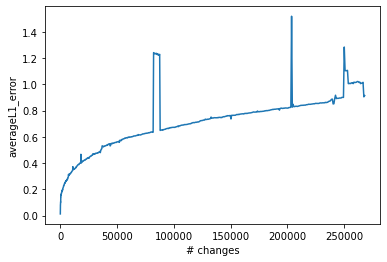

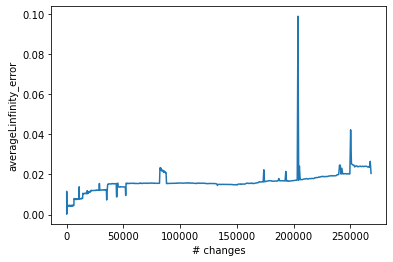

In [34]:
L1_error_graph(L1_metric)
Linfinity_error_graph(Linfinity_metric)